In [12]:
import random
import heapq
import matplotlib.pyplot as plt
import numpy as np
import json
import os

In [13]:
class Event:
    def __init__(self, time, customer_id, assigned_server_id, type):
        self.time = time
        self.customer_id = customer_id
        self.assigned_server_id = assigned_server_id
        self.type = type
    
    def __lt__(self, other):
        return self.time < other.time

    def __repr__(self):
        return f'(event_time: {self.time}, customer_id: {self.customer_id}, assigned_server_id: {self.assigned_server_id}, type: {self.type})'

In [3]:
class Customer:
    def __init__(self, arrival_time, customer_id, assigned_server_id, event_type):
        self.arrival_time = arrival_time
        self.customer_id = customer_id
        self.assigned_server_id = assigned_server_id
        self.event_type = event_type
    
    def __repr__(self):
        return f'(arrival_time: {self.arrival_time}, customer_id: {self.customer_id}, assigned_server_id: {self.assigned_server_id}, type: {self.event_type})'

In [4]:
class Server:
    def __init__(self, server_id, service_time, is_busy, busy_until, current_load, total_load):
        self.server_id = server_id
        self.service_time = service_time
        self.is_busy = is_busy
        self.busy_until = busy_until
        self.current_load = current_load
        self.total_load = total_load
    
    def start_serving(self, time):
        self.is_busy = True
        departure_time = time + self.service_time                    
        self.busy_until = departure_time

    def release_server(self):
        self.is_busy = False
        self.busy_until = None
        self.current_load -= 1
    
    def __repr__(self):
        return f'(server_id: {self.server_id}, service_time: {self.service_time}, is_busy: {self.is_busy}, busy_until: {self.busy_until}, current_load: {self.current_load}, total_load: {self.total_load})'

In [8]:
class Simulation:
    def __init__(self, interarrival_time, servers, num_servers, num_customers):
        self.interarrival_time = interarrival_time
        self.servers = servers
        self.num_servers = num_servers
        self.num_customers = num_customers
        self.customers = 0
        self.event_queue = []
        self.waiting_queue = []
        self.total_time_spent = 0
        self.max_time_spent = 0
        self.queue_size = [0]
    
    def schedule_new_event(self, time, customer_id, assigned_server_id, type):
        heapq.heappush(self.event_queue, Event(time, customer_id, assigned_server_id, type))

    def select_server_uniformly(self):
        server = random.choice(self.servers)
        return server
    
    def select_server_uniformly_with_power_of_d_choices(self, d_choices, servers_speed):
        d_servers = random.sample(self.servers, d_choices)
        minimum_load = min(server.current_load for server in d_servers)
        servers_with_equal_load = [server for server in d_servers if server.current_load == minimum_load]
        if servers_speed == 'different':
            fastest_from_equal_load = [server for server in servers_with_equal_load if server.service_time == min(server.service_time for server in servers_with_equal_load)]
            return fastest_from_equal_load[0]
        else:
            return random.choice(servers_with_equal_load)
            # Try choose first from list server_with_equal_load

    def run(self, scenario, d_choices, servers_speed):
        self.schedule_new_event(0, 0, None, 'arrival')
   
        while self.event_queue:
            event = heapq.heappop(self.event_queue) # time, customer_id, assigned_server_id, type
        
            if event.type == 'arrival':
                self.customers += 1

                if self.customers < self.num_customers:
                    # Schedule next customer arrival
                    self.schedule_new_event(event.time + self.interarrival_time, event.customer_id + 1, None, 'arrival')
                
                if scenario == 'uniform server selection':
                    choosen_server = self.select_server_uniformly()
                
                elif scenario == 'uniform server selection with power of d-choices':
                    choosen_server = self.select_server_uniformly_with_power_of_d_choices(d_choices, servers_speed)
                else:
                    raise Exception('Unknown scenario')

                choosen_server.current_load += 1
                choosen_server.total_load += 1

                if not choosen_server.is_busy:
                    choosen_server.start_serving(event.time)
                    self.total_time_spent += choosen_server.service_time
                    self.max_time_spent = max(self.max_time_spent, choosen_server.service_time)
                    # Schedule the departure event for the customer
                    self.schedule_new_event(choosen_server.busy_until, event.customer_id, choosen_server.server_id, 'departure')
                else:
                    # If the chosen server is busy, add a customer to the waiting queue
                    customer = Customer(event.time, event.customer_id, choosen_server.server_id, event.type)
                    self.waiting_queue.append(customer)
                    self.queue_size.append(len(self.waiting_queue))  
            
            elif event.type == 'departure': 
                server = self.servers[event.assigned_server_id]
                server.release_server()

                # If for this server is assigned customer in waiting_queue, start serving first from the list
                for waiting_customer in self.waiting_queue:
                    if waiting_customer.assigned_server_id == event.assigned_server_id:
                        server.start_serving(event.time)
                        waiting_time = event.time - waiting_customer.arrival_time
                        time_spent = waiting_time + server.service_time
                        self.total_time_spent += time_spent
                        self.max_time_spent = max(self.max_time_spent, time_spent)
                        # Schedule the departure event for the customer
                        self.schedule_new_event(server.busy_until, event.customer_id, event.assigned_server_id, 'departure')
                        # Remove customer from the waiting queue
                        self.waiting_queue.remove(waiting_customer)
                        break   

        avg_time_spent = (self.total_time_spent) / (self.customers)
        server_utilization = [round((server.total_load / self.customers) * 100, 4) for server in self.servers]
        avg_queue_size = np.mean(self.queue_size)

        return avg_time_spent, self.max_time_spent, server_utilization, avg_queue_size


In [9]:
def get_interarrival_time(arrival_rate):
    return random.expovariate(1.0 / arrival_rate)

def get_service_time(service_rate):
    return random.expovariate(1.0 / service_rate)

def initialize_servers(service_time, num_servers):
    return [Server(i, service_time[i], False, None, 0, 0) for i in range(num_servers)]

In [10]:
def experiment(params):
    data = {'avg_time_spent': [], 'max_time_spent': [], 'server_utilization': [], 'avg_queue_size': [], 'server_speed_to_load': []}
    
    for i in range(0, params['num_experiments']):
        servers = initialize_servers(params['service_times'][i], params['num_servers'])
        simulation = Simulation(params['interarrival_times'][i], servers, params['num_servers'], params['num_customers'])
        avg_time_spent, max_time_spent, server_utilization, avg_queue_size = simulation.run(params['scenario'], params['d_choices'], params['servers_speed'])
        data['avg_time_spent'].append(avg_time_spent)
        data['max_time_spent'].append(max_time_spent)
        data['server_utilization'].append(server_utilization)
        data['avg_queue_size'].append(avg_queue_size)
        data['server_speed_to_load'].extend(
            list(zip(
                [s.service_time for s in servers],
                server_utilization
            ))
        )
    data['server_speed_to_load'].sort(key=lambda x: x[0])

    return data

In [22]:
combined_data = {}
s1_uss, s1_uss_d2, s1_uss_d3, s1_uss_d5 = {}, {}, {}, {}
s2_uss, s2_uss_d2, s2_uss_d3, s2_uss_d5, s2_nuss_d2, s2_nuss_d3, s2_nuss_d5 = {}, {}, {}, {}, {}, {}, {}

service_rate = 1.0
num_servers = 5
num_customers = 10
num_experiments = 5

for arrival_rate in [0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]:
    print(arrival_rate)
    random.seed(0)
    interarrival_times = []
    same_service_times = []
    different_service_times = []
    service_time = get_service_time(service_rate)
    for _ in range(0, num_experiments):
        interarrival_times.append(get_interarrival_time(arrival_rate))
        same_service_times.append([service_time for _ in range(num_servers)])
        different_service_times.append([get_service_time(service_rate) for _ in range(num_servers)])
    
    print(interarrival_times)
    print(same_service_times)

    # scenario_1
    combined_data.setdefault('s1_uss', {})[arrival_rate] = experiment(
        {'num_servers': num_servers, 
        'num_customers': num_customers,
        'num_experiments': num_experiments,
        'interarrival_times': interarrival_times, 
        'service_times': same_service_times,
        'scenario': 'uniform server selection', 
        'd_choices': 0, 
        'servers_speed': 'same'})
    
    combined_data.setdefault('s1_uss_d2', {})[arrival_rate] = experiment(
        {'num_servers': num_servers, 
        'num_customers': num_customers,
        'num_experiments': num_experiments,
        'interarrival_times': interarrival_times, 
        'service_times': same_service_times,
        'scenario': 'uniform server selection with power of d-choices', 
        'd_choices': 2, 
        'servers_speed': 'same'})

    combined_data.setdefault('s1_uss_d3', {})[arrival_rate] = experiment(
        {'num_servers': num_servers, 
        'num_customers': num_customers,
        'num_experiments': num_experiments,
        'interarrival_times': interarrival_times, 
        'service_times': same_service_times,
        'scenario': 'uniform server selection with power of d-choices', 
        'd_choices': 3, 
        'servers_speed': 'same'})

    combined_data.setdefault('s1_uss_d5', {})[arrival_rate] = experiment(
        {'num_servers': num_servers, 
        'num_customers': num_customers,
        'num_experiments': num_experiments,
        'interarrival_times': interarrival_times, 
        'service_times': same_service_times,
        'scenario': 'uniform server selection with power of d-choices', 
        'd_choices': 5, 
        'servers_speed': 'same'})
    
    # scenario_2
    combined_data.setdefault('s2_uss', {})[arrival_rate] = experiment(
        {'num_servers': num_servers, 
        'num_customers': num_customers,
        'num_experiments': num_experiments,
        'interarrival_times': interarrival_times, 
        'service_times': different_service_times,
        'scenario': 'uniform server selection', 
        'd_choices': 0, 
        'servers_speed': 'different'})
    
    combined_data.setdefault('s2_uss_d2', {})[arrival_rate] = experiment(
        {'num_servers': num_servers, 
        'num_customers': num_customers,
        'num_experiments': num_experiments,
        'interarrival_times': interarrival_times, 
        'service_times': different_service_times,
        'scenario': 'uniform server selection with power of d-choices', 
        'd_choices': 2, 
        'servers_speed': 'different'})

    combined_data.setdefault('s2_uss_d3', {})[arrival_rate] = experiment(
        {'num_servers': num_servers, 
        'num_customers': num_customers,
        'num_experiments': num_experiments,
        'interarrival_times': interarrival_times, 
        'service_times': different_service_times,
        'scenario': 'uniform server selection with power of d-choices', 
        'd_choices': 3, 
        'servers_speed': 'different'})

    combined_data.setdefault('s2_uss_d5', {})[arrival_rate] = experiment(
        {'num_servers': num_servers, 
        'num_customers': num_customers,
        'num_experiments': num_experiments,
        'interarrival_times': interarrival_times, 
        'service_times': different_service_times,
        'scenario': 'uniform server selection with power of d-choices', 
        'd_choices': 5, 
        'servers_speed': 'different'})    



folder_path = './experiments/'
for key, value in combined_data.items():
    filename = f"{key}.json"
    file_path = os.path.join(folder_path, filename)
    with open(file_path, 'w') as file:
        json.dump(value, file)

0.5
[0.7093145764858809, 0.18070932166892512, 0.7048924667473893, 1.1622413037593837, 0.05306996970278806]
[[1.8606071110652234, 1.8606071110652234, 1.8606071110652234, 1.8606071110652234, 1.8606071110652234], [1.8606071110652234, 1.8606071110652234, 1.8606071110652234, 1.8606071110652234, 1.8606071110652234], [1.8606071110652234, 1.8606071110652234, 1.8606071110652234, 1.8606071110652234, 1.8606071110652234], [1.8606071110652234, 1.8606071110652234, 1.8606071110652234, 1.8606071110652234, 1.8606071110652234], [1.8606071110652234, 1.8606071110652234, 1.8606071110652234, 1.8606071110652234, 1.8606071110652234]]
0.7
[0.9930404070802332, 0.25299305033649516, 0.9868494534463449, 1.6271378252631372, 0.07429795758390328]
[[1.8606071110652234, 1.8606071110652234, 1.8606071110652234, 1.8606071110652234, 1.8606071110652234], [1.8606071110652234, 1.8606071110652234, 1.8606071110652234, 1.8606071110652234, 1.8606071110652234], [1.8606071110652234, 1.8606071110652234, 1.8606071110652234, 1.8606071

In [37]:
def read_all_experiments_data():
    folder_path = './experiments/'
    combined_data = {}

    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                data = json.load(file)
                key = filename[:-5]
                combined_data[key] = data
    
    return combined_data

def read_experiment_data(file_name):
    folder_path = './experiments/'
    file_path = os.path.join(folder_path, file_name)

    if os.path.exists(file_path):
        with open(file_path, 'r') as file:
            data = json.load(file)
    else:
        print(f"File '{file_name}' does not exist.")
    
    return data

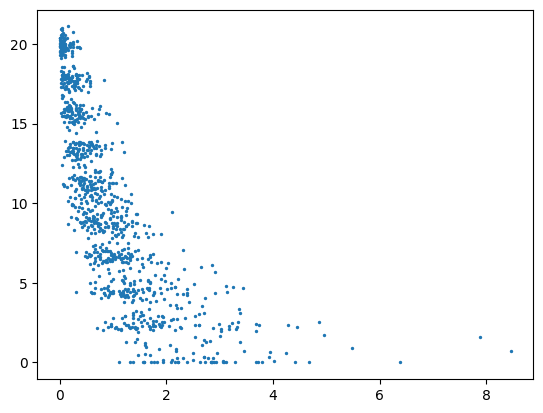

In [600]:
plt.scatter(*zip(*data_1['server_speed_to_load']), s=2)

In [789]:
def plot(data):
    for arrival_rate in [0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]:
        #data[arrival_rate]['avg_time_spent'].sort(key=lambda x: x[0])
        plt.plot(data[arrival_rate]['avg_time_spent'])
        plt.plot(data[arrival_rate]['avg_time_spent'])
        
        data[arrival_rate]['server_speed_to_load'].sort(key=lambda x: x[0])
        plt.scatter(*zip(*data[arrival_rate]['server_speed_to_load']), s=2)

        avg_time_spent = np.mean(data[arrival_rate]['avg_time_spent'])
        max_time_spent = np.mean(data[arrival_rate]['max_time_spent'])
        avg_queue_size = np.mean(data[arrival_rate]['avg_queue_size'])   

        print('Avg_time_spent: ', avg_time_spent)
        print('Max_time_spent: ', max_time_spent)
        print('Avg_queue_size: ', avg_queue_size)
        print()

mean_avg_time_spent 46.66149110346864
mean_avg_queue_size 262.3824097998403
mean_max_time_spent 417.9889295579269

mean_avg_time_spent_1 10.891918565567874
mean_avg_queue_size_1 143.7704448132747
mean_max_time_spent_1 61.94775546205838


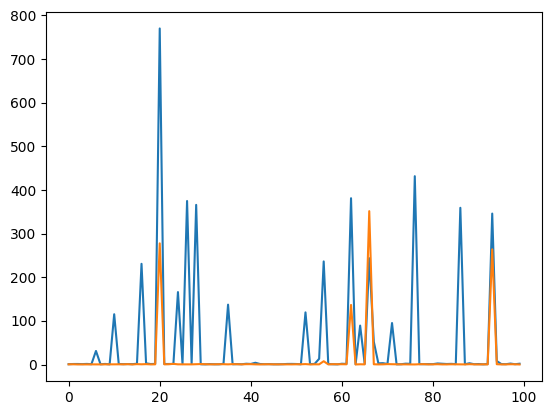

In [606]:
plot()

In [267]:
def plot(data):

    for arrival_rate in [0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]:
        #sorted_idx = sorted(list(range(0, len(data[arrival_rate]['avg_time_spent']))), key=lambda i: data[arrival_rate]['avg_time_spent'][i], reverse=True)
        for i in range(0, 10000, 10):
            #plt.plot(data[arrival_rate]['avg_time_spent'][sorted_idx[i]])
            plt.plot(data[arrival_rate]['avg_time_spent'])

        mean_avg_time_spent = np.mean(data[arrival_rate]['avg_time_spent'])
        mean_avg_queue_size = np.mean(data[arrival_rate]['avg_queue_size'])
        mean_max_load = np.mean(data[arrival_rate]['max_load'])

    #plt.show()
    print('mean_avg_time_spent', mean_avg_time_spent)
    print('mean_avg_queue_size', mean_avg_queue_size)
    print('mean_max_load', mean_max_load)


# Pierwszy scenariusz

### Identyczne serwery i zadania

#### a) jednostajny wybór serwera

In [268]:
data = experiment(d_choices=0, scenario='uniform server selection', servers_speed='same')

In [ ]:
plot(data)

In [ ]:
plot(experiment(d_choices=False, scenario='uniform server selection', servers_speed='same'))

#### b) wybór mniej obciążonego z 2 jednostajnie wybranych serwerów

mean_avg_time_spent 2.579543142378132
mean_avg_queue_size 1.2311956517109488
mean_max_load 122.785


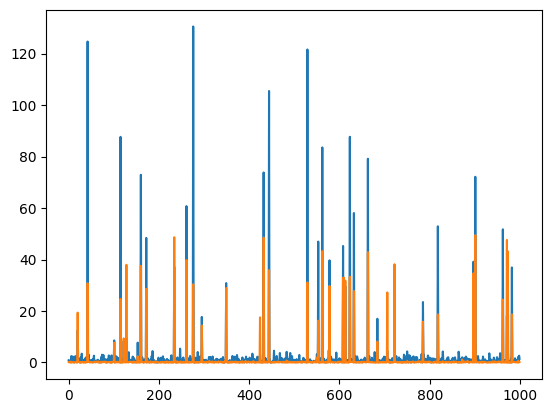

In [ ]:
plot(experiment(d_choices=2, scenario='uniform server selection with power of d-choices', servers_speed='same'))

#### c) wybór mniej obciążonego z d jednostajnie wybranych serwerów

In [ ]:
same_speeds_3_choices = experiment(d_choices=3, scenario='uniform server selection with power of d-choices', servers_speed='same')

mean_avg_time_spent 2.1883936599868594
mean_avg_queue_size 1.0004780104574647


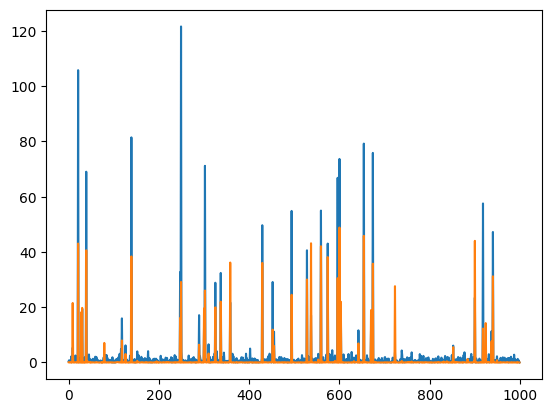

In [ ]:
plot(same_speeds_3_choices)

# Drugi scenariusz

### Serwery o różnej szybkości, takie same zadania

#### a) jednostajny wybór serwera

In [ ]:
different_servers_uniform_choice = experiment(d_choices=False, scenario='uniform server selection', servers_speed='different')

mean_avg_time_spent 2.5721575238612258
mean_avg_queue_size 1.882056464671077


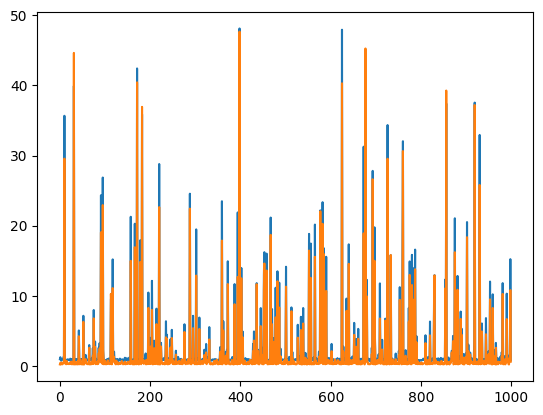

In [ ]:
plot(different_servers_uniform_choice)

#### b) wybór mniej obciążonego z 2 jednostajnie wybranych serwerów

In [ ]:
different_servers_2_choices = experiment(d_choices=2, scenario='uniform server selection with power of d-choices', servers_speed='different')

mean_avg_time_spent 0.7311838693043273
mean_avg_queue_size 0.6153893307721228


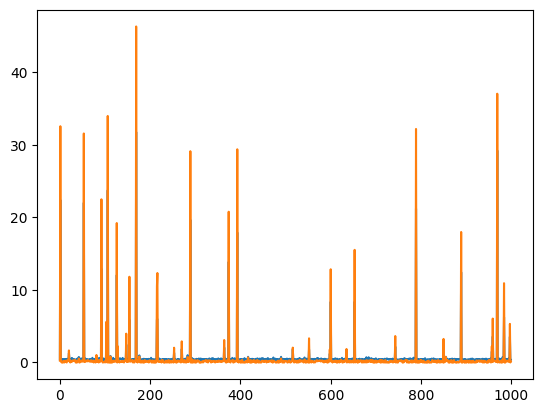

In [ ]:
plot(different_servers_2_choices)

#### c) wybór mniej obciążonego z d jednostajnie wybranych serwerów

mean_avg_time_spent 0.41094670807312256
mean_avg_queue_size 0.20623101064012975


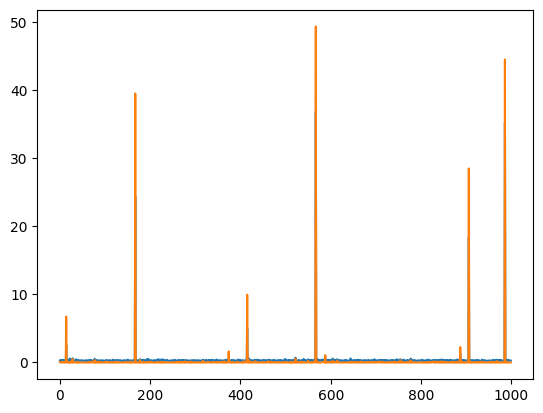

In [ ]:
plot(experiment(d_choices=3, scenario='uniform server selection with power of d-choices', servers_speed='different'))

#### d) wybór mniej obciążonego z 2 niejednostajnie wybranych serwerów

#### e) wybór mniej obciążonego z d niejednostajnie wybranych serwerów

# Trzeci scenariusz

### Serwery o różnej szybkości, różne zadania

#### a) jednostajny wybór serwera

#### b) wybór mniej obciążonego z 2 jednostajnie wybranych serwerów

#### c) wybór mniej obciążonego z d jednostajnie wybranych serwerów

#### d) wybór mniej obciążonego z 2 niejednostajnie wybranych serwerów

#### e) wybór mniej obciążonego z d niejednostajnie wybranych serwerów